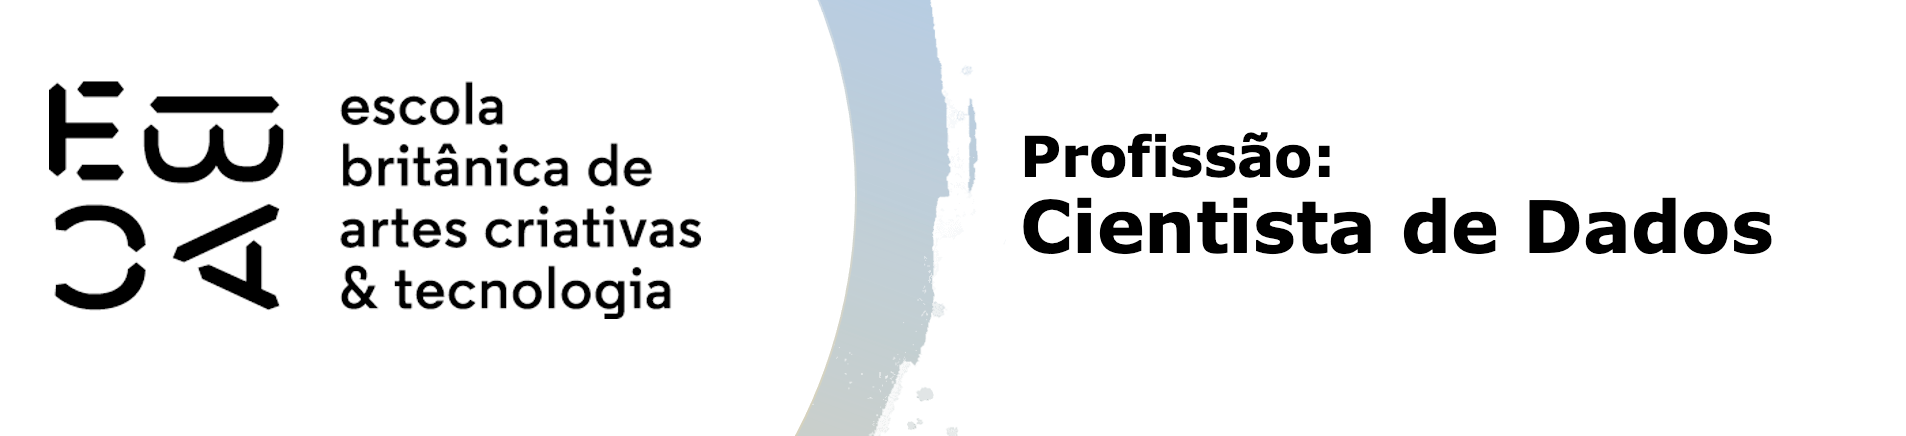

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
ultimas_safras = (df["data_ref"].sort_values().unique()[-3:])

df_oot = df[df["data_ref"].isin(ultimas_safras)].copy()
df_dev = df[~df["data_ref"].isin(ultimas_safras)].copy()

In [3]:
variaveis_explicativas = [col for col in df.columns if col not in ["data_ref", "index"]]

X_dev = df_dev[variaveis_explicativas]
y_dev = df_dev["mau"]

X_oot = df_oot[variaveis_explicativas]
y_oot = df_oot["mau"]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
df.shape[0]

750000

In [5]:
df["data_ref"].value_counts().sort_index()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [6]:
variaveis_quant = df.select_dtypes(include=["int64", "float64"]).columns
variaveis_qual = df.select_dtypes(include=["object", "category", "bool"]).columns

In [7]:
df[variaveis_quant].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
index,750000.0,8319.27,4809.28,0.00,4147.00,8324.00,12487.00,16649.00
qtd_filhos,750000.0,0.43,0.74,0.00,0.00,0.00,1.00,14.00
idade,750000.0,43.80,11.23,22.00,34.00,43.00,53.00,68.00
tempo_emprego,624043.0,7.75,6.69,0.12,3.05,6.05,10.18,42.91
qt_pessoas_residencia,750000.0,2.21,0.90,1.00,2.00,2.00,3.00,15.00
renda,750000.0,23238.54,79106.01,107.67,3467.70,7861.82,18318.28,4083986.22


In [8]:
analise_qual = []

for col in variaveis_qual:
    freq = df[col].value_counts(normalize=True)
    analise_qual.append({
        "variavel": col,
        "n_categorias": df[col].nunique(),
        "categoria_mais_frequente": freq.index[0],
        "proporcao_mais_frequente": freq.iloc[0],
        "categoria_menos_frequente": freq.index[-1],
        "proporcao_menos_frequente": freq.iloc[-1]
    })

df_analise_qual = pd.DataFrame(analise_qual)
df_analise_qual

,variavel,n_categorias,categoria_mais_frequente,proporcao_mais_frequente,categoria_menos_frequente,proporcao_menos_frequente
0,sexo,2,F,0.672773,M,0.327227
1,posse_de_veiculo,2,N,0.610605,S,0.389395
2,posse_de_imovel,2,S,0.671589,N,0.328411
3,tipo_renda,5,Assalariado,0.514320,Bolsista,0.000481
4,educacao,5,Médio,0.675781,Pós graduação,0.001083
5,estado_civil,5,Casado,0.701963,Viúvo,0.042151
6,tipo_residencia,6,Casa,0.899059,Comunitário,0.004387
7,mau,2,False,0.921809,True,0.078191


Variáveis não indicam cardinalidade baixa para média, o que é adequado para credit scoring, algumas classes domintantes e a varável resposta mostra um desbalanceamento, tendo aproximadamente 7,8% inadimplentes

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

**Análise realizada utilizando streamlit**

[Descritiva Bivariada](https://ebac-credit-scoring.onrender.com)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
import numpy as np

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [10]:
cols_excluir = ["index", "data_ref"]
df_model = df_dev.drop(columns=cols_excluir)

df_model.isna().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [11]:
df_model.loc[(df_model.tempo_emprego.isna()),"tipo_renda"].value_counts()

tipo_renda
Pensionista    100875
Name: count, dtype: int64

No caso de tempo emprego igual a vazio, a base nos mostra que esses registros estão representando individuos com o tipo_renda pensionista, para não impactar a analise, não vamos retirar esses registros da base, apenas alterar de vazio para 0

In [12]:
df_model = df_model.fillna(0)

In [13]:
metadados = pd.DataFrame(df_model.dtypes, columns=['dtype'])
metadados['nmissing'] = df_model.isna().sum()
metadados['valores_unicos'] = df_model.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [14]:
var='idade'
IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)

0.01796842289500074

In [15]:
for var in metadados[metadados.papel == "covariavel"].index:
    if (metadados.loc[var, "valores_unicos"]>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045
idade,int64,0.0,47.0,covariavel,0.017968
tempo_emprego,float64,0.0,3005.0,covariavel,0.351920


Realizando o calculo do IV de cada covariavel na base, conseguimos observar onde estão as principais váriaveis explicativas dessa base de dados, considerando nossa variável resposta. Onde a renda e o tempo_emprego nos dão as principais respostas, ficando acima de 0.02, a demais não descriminam muito sobre a variavel resposta. Podemos tentar salvar a váriavel idade, que fica proxima do 0.02

In [16]:
from scipy.stats import t
import matplotlib.pyplot as plt

def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


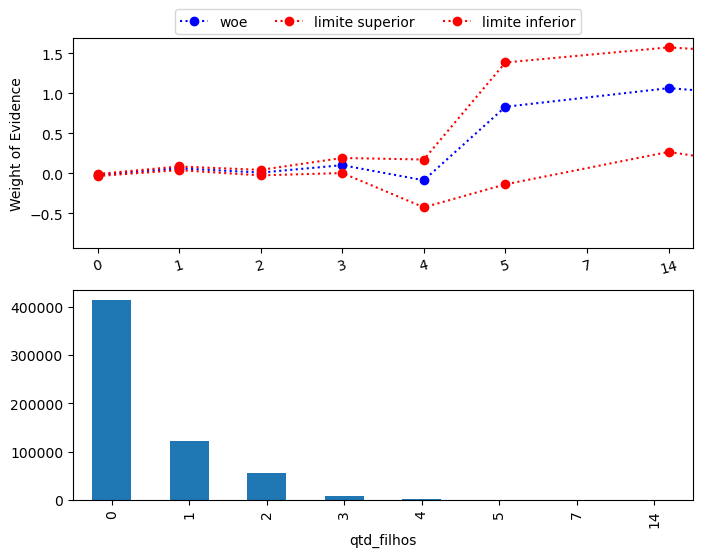

In [ ]:
biv_discreta("qtd_filhos", df_model)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


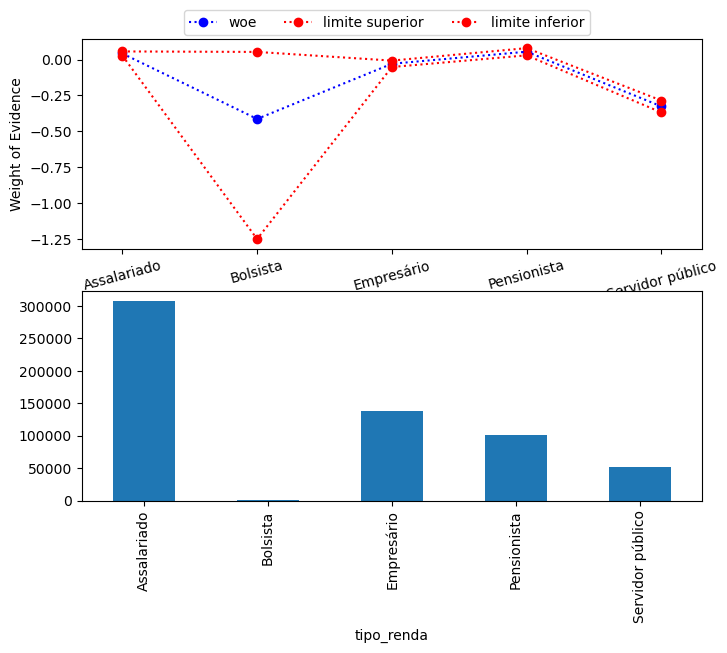

In [ ]:
biv_discreta("tipo_renda", df_model)

Conforme observamos, as váriaveis discretas discriminam quase nada da nossa variável resposta, vamos agora analisar as váriaveis que se sairam melho no IV, e todas são variáveis continuas

In [ ]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\VIPEXGRUNT182\AppData\Local\Temp\ipykernel_25036\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


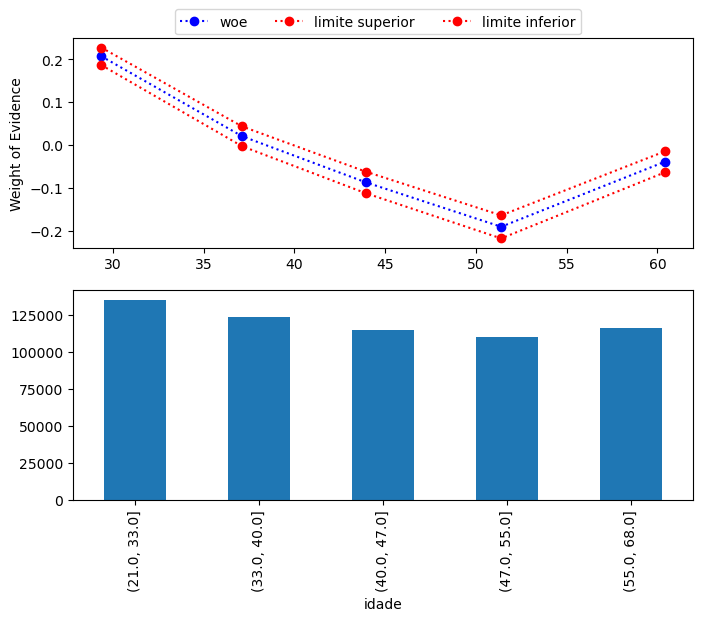

In [ ]:
biv_continua("idade", 5, df_model)

C:\Users\VIPEXGRUNT182\AppData\Local\Temp\ipykernel_25036\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


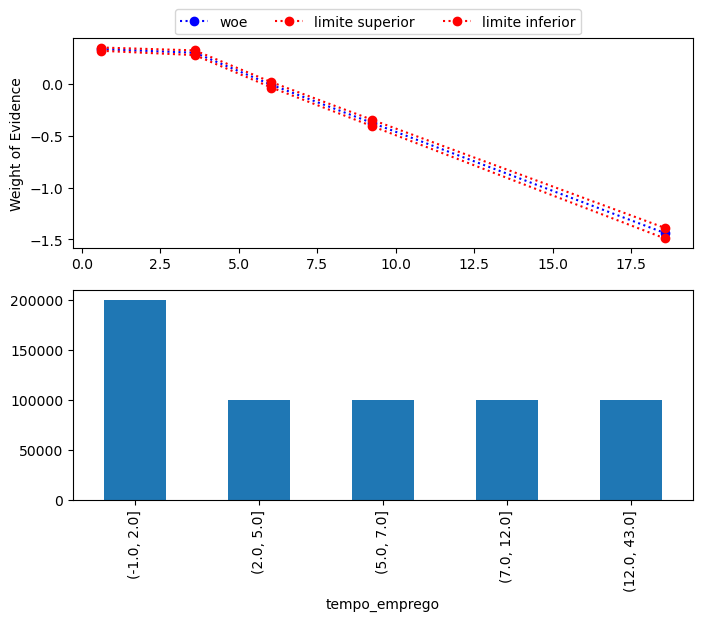

In [ ]:
biv_continua("tempo_emprego", 6, df_model)

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [ ]:
" + ".join(list(df_model.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [ ]:
formula = """
    mau ~ sexo + posse_de_veiculo 
    + posse_de_imovel + qtd_filhos 
    + tipo_renda + educacao + estado_civil 
    + tipo_residencia + idade + tempo_emprego 
    + qt_pessoas_residencia + renda
"""

rl = smf.glm(formula, data=df_model, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599974
Model Family:                         Binomial   Df Model:                           25
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2483e+05
Date:                         Mon, 29 Dec 2025   Deviance:                   2.4966e+05
Time:                                 08:40:07   Pearson chi2:                 1.62e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04277
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1293      0.192      5.867      0.000       0.752       1.507
sexo[T.M]                            0.1263      0.013      9.621      0.000       0.101       0.152
posse_de_veiculo[T.S]               -0.0320      0.012     -2.588      0.010      -0.056      -0.008
posse_de_imovel[T.S]                 0.0857      0.012      7.256      0.000       0.063       0.109
tipo_renda[T.Bolsista]              -0.1248      0.300     -0.416      0.678      -0.713       0.463
tipo_renda[T.Empresário]             0.0531      0.014      3.789      0.000       0.026       0.081
tipo_renda[T.Pensionista]            0.2216      0.022     10.012      0.000       0.178       0.265
tipo_renda[T.Servidor público]       0.0319      0.023      1.373      0.170      -0.014       0.077
educacao[T.Médio]                    0.0304      0.049      0.623      0.533      -0.065       0.126
educacao[T.Pós graduação]            0.0456      0.168      0.272      0.786      -0.283       0.374
educacao[T.Superior completo]        0.0902      0.050      1.812      0.070      -0.007       0.188
educacao[T.Superior incompleto]      0.0803      0.056      1.440      0.150      -0.029       0.189
estado_civil[T.Separado]             0.0856      0.092      0.926      0.354      -0.096       0.267
estado_civil[T.Solteiro]             0.1160      0.090      1.282      0.200      -0.061       0.293
estado_civil[T.União]               -0.0474      0.020     -2.329      0.020      -0.087      -0.008
estado_civil[T.Viúvo]                0.1575      0.094      1.675      0.094      -0.027       0.342
tipo_residencia[T.Casa]              0.0890      0.044      2.020      0.043       0.003       0.175
tipo_residencia[T.Com os pais]       0.0743      0.050      1.499      0.134      -0.023       0.171
tipo_residencia[T.Comunitário]       0.1399      0.089      1.565      0.118      -0.035       0.315
tipo_residencia[T.Estúdio]           0.0337      0.082      0.408      0.683      -0.128       0.195
tipo_residencia[T.Governamental]     0.0861      0.053      1.615      0.106      -0.018       0.191
qtd_filhos                          -0.1269      0.090     -1.416      0.157      -0.302       0.049
idade                            -6.696e-05      0.001     -0.095      0.924      -0.001       0.001
tempo_emprego                        0.0236      0.002     13.091      0.000       0.020       0.027
qt_pessoas_residencia                0.1237      0.089      1.384      0.166      -0.051       0.299
renda                                0.0001   1.09e-06     93.670      0.000    9.96e-05       0.000
=======================================================

O modelo apresenta comportamento consistente com aplicações de credit scoring, com pseudo-R² compatível com o mercado, variáveis economicamente interpretáveis e boa significância estatística. Algumas variáveis exigem transformação para capturar efeitos não lineares, especialmente idade, renda e tempo de emprego, além de agrupamentos para categorias pouco informativas.

In [ ]:
df_model_2 = df_model.copy()

In [ ]:
df_model_2["idade"].isna().mean()

0.0

In [ ]:
df_model_2['idade'].describe()

count    600000.000000
mean         43.798530
std          11.230659
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64

In [ ]:
bins_idade = [21, 24, 34, 44, 54, 64, 68]
labels_idade = [
    "22_24",
    "25_34",
    "35_44",
    "45_54",
    "55_64",
    "65_68"
]
df_model_2["idade_bin"] = pd.cut(
    df_model_2["idade"],
    bins=bins_idade,
    labels=labels_idade,
    include_lowest=True
)

In [ ]:
df_model_2["idade_bin"].value_counts(normalize=True).sort_index().sort_values(ascending=True)

idade_bin
22_24    0.009182
65_68    0.022750
55_64    0.188830
45_54    0.244693
25_34    0.244942
35_44    0.289603
Name: proportion, dtype: float64

In [ ]:
df_model_2.groupby("idade_bin")["mau"].mean().sort_index()

C:\Users\VIPEXGRUNT182\AppData\Local\Temp\ipykernel_25036\4238941595.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model_2.groupby("idade_bin")["mau"].mean().sort_index()


idade_bin
22_24    0.101107
25_34    0.071990
35_44    0.059374
45_54    0.052896
55_64    0.058306
65_68    0.059853
Name: mau, dtype: float64

In [ ]:
formula = """
    mau ~ sexo + posse_de_veiculo 
    + posse_de_imovel + qtd_filhos 
    + tipo_renda + educacao + estado_civil 
    + tipo_residencia + C(idade_bin) + tempo_emprego 
    + qt_pessoas_residencia + renda
"""

rl = smf.glm(formula, data=df_model_2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599970
Model Family:                         Binomial   Df Model:                           29
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2482e+05
Date:                         Mon, 29 Dec 2025   Deviance:                   2.4965e+05
Time:                                 09:53:42   Pearson chi2:                 1.61e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04279
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9782      0.196      4.981      0.000       0.593       1.363
sexo[T.M]                            0.1291      0.013      9.814      0.000       0.103       0.155
posse_de_veiculo[T.S]               -0.0322      0.012     -2.601      0.009      -0.057      -0.008
posse_de_imovel[T.S]                 0.0858      0.012      7.255      0.000       0.063       0.109
tipo_renda[T.Bolsista]              -0.1243      0.300     -0.414      0.679      -0.713       0.464
tipo_renda[T.Empresário]             0.0528      0.014      3.772      0.000       0.025       0.080
tipo_renda[T.Pensionista]            0.2341      0.025      9.202      0.000       0.184       0.284
tipo_renda[T.Servidor público]       0.0338      0.023      1.453      0.146      -0.012       0.079
educacao[T.Médio]                    0.0313      0.049      0.641      0.522      -0.064       0.127
educacao[T.Pós graduação]            0.0484      0.168      0.288      0.773      -0.281       0.378
educacao[T.Superior completo]        0.0908      0.050      1.823      0.068      -0.007       0.188
educacao[T.Superior incompleto]      0.0881      0.056      1.579      0.114      -0.021       0.198
estado_civil[T.Separado]             0.0844      0.093      0.912      0.362      -0.097       0.266
estado_civil[T.Solteiro]             0.1199      0.091      1.323      0.186      -0.058       0.298
estado_civil[T.União]               -0.0477      0.020     -2.345      0.019      -0.088      -0.008
estado_civil[T.Viúvo]                0.1600      0.094      1.698      0.089      -0.025       0.345
tipo_residencia[T.Casa]              0.0899      0.044      2.041      0.041       0.004       0.176
tipo_residencia[T.Com os pais]       0.0800      0.050      1.612      0.107      -0.017       0.177
tipo_residencia[T.Comunitário]       0.1400      0.089      1.565      0.118      -0.035       0.315
tipo_residencia[T.Estúdio]           0.0312      0.082      0.378      0.705      -0.130       0.193
tipo_residencia[T.Governamental]     0.0910      0.053      1.705      0.088      -0.014       0.196
C(idade_bin)[T.25_34]                0.1535      0.047      3.258      0.001       0.061       0.246
C(idade_bin)[T.35_44]                0.1520      0.048      3.187      0.001       0.059       0.246
C(idade_bin)[T.45_54]                0.1501      0.048      3.116      0.002       0.056       0.244
C(idade_bin)[T.55_64]                0.1324      0.052      2.568      0.010       0.031       0.233
C(idade_bin)[T.65_68]                0.1177      0.064      1.843      0.065      -0.007       0.243
qtd_filhos                          -0.1285      0.090 

A variável idade, quando utilizada de forma contínua, não apresentou significância estatística nem interpretação econômica adequada. Após a aplicação de binning supervisionado, observou-se comportamento consistente com a teoria de risco de crédito, com redução significativa da inadimplência a partir da faixa etária de 25 anos, atingindo o menor risco entre 45 e 54 anos. As novas categorias apresentaram coeficientes estatisticamente significantes e interpretáveis, justificando a transformação aplicada.

In [ ]:
df_model_2["renda"] = df_model_2["renda"].astype(float)
df_model_2["renda"].isna().mean()

0.0

In [ ]:
df_model_2["renda"].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

count    6.000000e+05
mean     2.722284e+04
std      8.737788e+04
min      1.618600e+02
1%       8.582000e+02
5%       1.689389e+03
25%      4.670600e+03
50%      9.887580e+03
75%      2.162887e+04
95%      8.975213e+04
99%      3.262481e+05
max      4.083986e+06
Name: renda, dtype: float64

In [ ]:
(df_model_2['renda'] == 0).mean()

0.0

A variável renda apresenta distribuição altamente assimétrica, com cauda longa e presença de valores extremos, o que inviabiliza sua utilização na forma linear. Dessa forma, optou-se pela transformação logarítmica para estabilizar a variância e capturar o efeito marginal decrescente da renda sobre o risco de crédito.

In [ ]:
df_model_2["log_renda"] = np.log1p(df_model_2["renda"])

In [ ]:
df_model_2["log_renda"].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

count    600000.000000
mean          9.270624
std           1.211877
min           5.092891
1%            6.756002
5%            7.432714
25%           8.449257
50%           9.199136
75%           9.981831
95%          11.404818
99%          12.695416
max          15.222584
Name: log_renda, dtype: float64

In [ ]:
df_model_2['log_renda_dec'] = pd.qcut(df_model_2['log_renda'],q=10,duplicates='drop')

df_model_2.groupby("log_renda_dec")["mau"].mean()

C:\Users\VIPEXGRUNT182\AppData\Local\Temp\ipykernel_25036\2502723474.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model_2.groupby("log_renda_dec")["mau"].mean()


log_renda_dec
(5.092, 7.805]      0.217683
(7.805, 8.27]       0.112294
(8.27, 8.615]       0.079657
(8.615, 8.914]      0.058892
(8.914, 9.199]      0.046067
(9.199, 9.484]      0.035048
(9.484, 9.802]      0.026168
(9.802, 10.191]     0.018566
(10.191, 10.801]    0.012018
(10.801, 15.223]    0.004317
Name: mau, dtype: float64

Clientes de renda mais elevada apresentam risco significativamente menor, com redução gradual e contínua da inadimplência conforme a renda aumenta.

In [ ]:
formula = """
    mau ~ sexo + posse_de_veiculo 
    + posse_de_imovel + qtd_filhos 
    + tipo_renda + educacao + estado_civil 
    + tipo_residencia + C(idade_bin) + tempo_emprego 
    + qt_pessoas_residencia + log_renda
"""

rl = smf.glm(formula, data=df_model_2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599970
Model Family:                         Binomial   Df Model:                           29
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2026e+05
Date:                         Mon, 29 Dec 2025   Deviance:                   2.4052e+05
Time:                                 10:19:16   Pearson chi2:                 5.97e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.05724
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.2011      0.201    -30.779      0.000      -6.596      -5.806
sexo[T.M]                            0.0098      0.013      0.726      0.468      -0.017       0.036
posse_de_veiculo[T.S]               -0.0300      0.013     -2.376      0.018      -0.055      -0.005
posse_de_imovel[T.S]                 0.0176      0.012      1.455      0.146      -0.006       0.041
tipo_renda[T.Bolsista]              -0.2106      0.300     -0.703      0.482      -0.798       0.377
tipo_renda[T.Empresário]             0.0051      0.014      0.354      0.723      -0.023       0.033
tipo_renda[T.Pensionista]            0.0128      0.026      0.498      0.618      -0.038       0.063
tipo_renda[T.Servidor público]      -0.0043      0.024     -0.182      0.856      -0.051       0.042
educacao[T.Médio]                   -0.0049      0.050     -0.098      0.922      -0.103       0.093
educacao[T.Pós graduação]           -0.0748      0.171     -0.436      0.663      -0.411       0.261
educacao[T.Superior completo]       -0.0020      0.051     -0.039      0.969      -0.102       0.098
educacao[T.Superior incompleto]     -0.0149      0.057     -0.261      0.794      -0.127       0.097
estado_civil[T.Separado]             0.1032      0.092      1.120      0.263      -0.077       0.284
estado_civil[T.Solteiro]             0.1003      0.090      1.114      0.265      -0.076       0.277
estado_civil[T.União]               -0.0571      0.021     -2.748      0.006      -0.098      -0.016
estado_civil[T.Viúvo]                0.1135      0.094      1.210      0.226      -0.070       0.297
tipo_residencia[T.Casa]              0.0154      0.045      0.339      0.735      -0.074       0.104
tipo_residencia[T.Com os pais]      -0.0156      0.051     -0.307      0.759      -0.116       0.084
tipo_residencia[T.Comunitário]       0.0966      0.092      1.050      0.294      -0.084       0.277
tipo_residencia[T.Estúdio]          -0.0353      0.085     -0.417      0.676      -0.201       0.130
tipo_residencia[T.Governamental]     0.0079      0.055      0.144      0.886      -0.100       0.115
C(idade_bin)[T.25_34]                0.0913      0.048      1.884      0.060      -0.004       0.186
C(idade_bin)[T.35_44]                0.0759      0.049      1.548      0.122      -0.020       0.172
C(idade_bin)[T.45_54]                0.0559      0.050      1.129      0.259      -0.041       0.153
C(idade_bin)[T.55_64]                0.0511      0.053      0.967      0.334      -0.052       0.155
C(idade_bin)[T.65_68]                0.0199      0.065      0.305      0.761      -0.108       0.148
qtd_filhos                          -0.1125      0.089 

A variável renda foi substituída por sua transformação logarítmica, devido à forte assimetria e presença de valores extremos. A transformação permitiu capturar o efeito marginal decrescente da renda sobre o risco de crédito, resultando em coeficiente estatisticamente significante e economicamente interpretável.

Utilizar o log de renda no nosso modelo, nos mostrou como esta variável é dominante sobre as demais, nos deixando com poucas variáveis significantes restantes, sendo elas posse_de_veiculo[T.S], estado_civil[T.União] e C(idade_bin)[T.25_34]. E com nosso pseudo R² em 0.057, um nivel já aceitavel, mas ainda precisamos transformar a variável tempo emprego

In [ ]:
df_model_2["tempo_emprego"].isna().mean()

0.0

In [ ]:
df_model_2["tempo_emprego"].describe()

count    600000.000000
mean          6.445361
std           6.753633
min           0.000000
25%           1.180822
50%           4.687671
75%           9.069863
max          42.906849
Name: tempo_emprego, dtype: float64

In [ ]:
df_model_2["emprego_zero"] = (df_model_2["tempo_emprego"] == 0).astype(int)
df_model_2["log_tempo_emprego"] = np.log1p(df_model_2["tempo_emprego"])

In [ ]:
bins_emprego = [-0.01, 0, 1, 3, 5, 10, 20, 50]
labels_emprego = [
    "0",
    "0_1",
    "1_3",
    "3_5",
    "5_10",
    "10_20",
    "20+"
]

df_model_2["tempo_emprego_bin"] = pd.cut(
    df_model_2["tempo_emprego"],
    bins=bins_emprego,
    labels=labels_emprego
)

In [ ]:
df_model_2["tempo_emprego_bin"].value_counts(normalize=True)

tempo_emprego_bin
5_10     0.261203
0        0.168125
10_20    0.161837
3_5      0.150623
1_3      0.140285
0_1      0.063805
20+      0.054122
Name: proportion, dtype: float64

In [ ]:
df_model_2.groupby("tempo_emprego_bin")["mau"].mean()

C:\Users\VIPEXGRUNT182\AppData\Local\Temp\ipykernel_25036\4035509265.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model_2.groupby("tempo_emprego_bin")["mau"].mean()


tempo_emprego_bin
0        0.064218
0_1      0.112060
1_3      0.094201
3_5      0.077589
5_10     0.053177
10_20    0.024469
20+      0.006898
Name: mau, dtype: float64

O tempo de emprego apresenta relação não linear e monotônica com o risco de inadimplência, com maior risco concentrado nos primeiros anos de vínculo e redução consistente conforme o tempo de permanência aumenta.

In [ ]:
formula = """
    mau ~ sexo + posse_de_veiculo 
    + posse_de_imovel + qtd_filhos 
    + tipo_renda + educacao + estado_civil 
    + tipo_residencia + C(idade_bin)
    + qt_pessoas_residencia + log_renda 
    + emprego_zero + C(tempo_emprego_bin)
"""

rl = smf.glm(formula, data=df_model_2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599965
Model Family:                         Binomial   Df Model:                           34
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2026e+05
Date:                         Mon, 29 Dec 2025   Deviance:                   2.4052e+05
Time:                                 10:42:15   Pearson chi2:                 5.96e+05
No. Iterations:                            100   Pseudo R-squ. (CS):            0.05724
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -5.4526      0.180    -30.263      0.000      -5.806      -5.099
sexo[T.M]                            0.0089      0.013      0.663      0.508      -0.017       0.035
posse_de_veiculo[T.S]               -0.0301      0.013     -2.381      0.017      -0.055      -0.005
posse_de_imovel[T.S]                 0.0169      0.012      1.392      0.164      -0.007       0.041
tipo_renda[T.Bolsista]              -0.2201      0.301     -0.732      0.464      -0.809       0.369
tipo_renda[T.Empresário]             0.0039      0.014      0.274      0.784      -0.024       0.032
tipo_renda[T.Pensionista]            0.0506      0.232      0.218      0.828      -0.404       0.506
tipo_renda[T.Servidor público]      -0.0029      0.024     -0.124      0.901      -0.049       0.043
educacao[T.Médio]                   -0.0035      0.050     -0.070      0.944      -0.102       0.095
educacao[T.Pós graduação]           -0.0793      0.172     -0.462      0.644      -0.415       0.257
educacao[T.Superior completo]       -0.0017      0.051     -0.033      0.973      -0.102       0.098
educacao[T.Superior incompleto]     -0.0116      0.057     -0.204      0.839      -0.124       0.100
estado_civil[T.Separado]             0.1014      0.092      1.100      0.271      -0.079       0.282
estado_civil[T.Solteiro]             0.0987      0.090      1.095      0.273      -0.078       0.275
estado_civil[T.União]               -0.0588      0.021     -2.827      0.005      -0.100      -0.018
estado_civil[T.Viúvo]                0.1114      0.094      1.188      0.235      -0.072       0.295
tipo_residencia[T.Casa]              0.0138      0.045      0.304      0.761      -0.075       0.103
tipo_residencia[T.Com os pais]      -0.0181      0.051     -0.353      0.724      -0.118       0.082
tipo_residencia[T.Comunitário]       0.0958      0.092      1.040      0.298      -0.085       0.276
tipo_residencia[T.Estúdio]          -0.0358      0.085     -0.424      0.672      -0.202       0.130
tipo_residencia[T.Governamental]     0.0061      0.055      0.111      0.911      -0.101       0.114
C(idade_bin)[T.25_34]                0.0947      0.049      1.952      0.051      -0.000       0.190
C(idade_bin)[T.35_44]                0.0803      0.049      1.635      0.102      -0.016       0.176
C(idade_bin)[T.45_54]                0.0604      0.050      1.220      0.223      -0.037       0.158
C(idade_bin)[T.55_64]                0.0558      0.053      1.056      0.291      -0.048       0.160
C(idade_bin)[T.65_68]                0.0247      0.065      0.378      0.705      -0.103       0.153
C(tempo_emprego_bin)[T.0_1]         -0.7765      0.042 

A estabilidade do pseudo R² indica que as transformações melhoraram a forma funcional e a interpretabilidade do modelo, sem adicionar nova informação preditiva. O próximo passo é reduzir complexidade removendo variáveis estatisticamente fracas e sem racional de negócio, priorizando estabilidade, parcimônia e leitura econômica.

In [ ]:
formula_reduzida = """
    mau ~ + posse_de_veiculo
    + posse_de_imovel + qtd_filhos 
    + estado_civil + C(idade_bin)
    + qt_pessoas_residencia + log_renda 
    + emprego_zero + C(tempo_emprego_bin)
"""

rl_2 = smf.glm(formula_reduzida, data=df_model_2, family=sm.families.Binomial()).fit()

rl_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599979
Model Family:                         Binomial   Df Model:                           20
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2026e+05
Date:                         Mon, 29 Dec 2025   Deviance:                   2.4052e+05
Time:                                 10:50:11   Pearson chi2:                 5.96e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.05724
Covariance Type:                     nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -5.4422      0.168    -32.429      0.000      -5.771      -5.113
posse_de_veiculo[T.S]            -0.0269      0.012     -2.262      0.024      -0.050      -0.004
posse_de_imovel[T.S]              0.0187      0.012      1.578      0.115      -0.005       0.042
estado_civil[T.Separado]          0.0982      0.092      1.067      0.286      -0.082       0.279
estado_civil[T.Solteiro]          0.0960      0.090      1.067      0.286      -0.080       0.272
estado_civil[T.União]            -0.0595      0.021     -2.869      0.004      -0.100      -0.019
estado_civil[T.Viúvo]             0.1089      0.094      1.162      0.245      -0.075       0.292
C(idade_bin)[T.25_34]             0.0972      0.048      2.017      0.044       0.003       0.192
C(idade_bin)[T.35_44]             0.0853      0.048      1.761      0.078      -0.010       0.180
C(idade_bin)[T.45_54]             0.0652      0.049      1.336      0.181      -0.030       0.161
C(idade_bin)[T.55_64]             0.0617      0.052      1.183      0.237      -0.041       0.164
C(idade_bin)[T.65_68]             0.0307      0.065      0.475      0.635      -0.096       0.158
C(tempo_emprego_bin)[T.0_1]      -0.7808      0.029    -26.765      0.000      -0.838      -0.724
C(tempo_emprego_bin)[T.1_3]      -0.7526      0.027    -27.633      0.000      -0.806      -0.699
C(tempo_emprego_bin)[T.3_5]      -0.7821      0.028    -28.387      0.000      -0.836      -0.728
C(tempo_emprego_bin)[T.5_10]     -0.7731      0.028    -28.053      0.000      -0.827      -0.719
C(tempo_emprego_bin)[T.10_20]    -0.7544      0.033    -22.916      0.000      -0.819      -0.690
C(tempo_emprego_bin)[T.20+]      -0.8308      0.066    -12.519      0.000      -0.961      -0.701
qtd_filhos                       -0.1092      0.089     -1.226      0.220      -0.284       0.065
qt_pessoas_residencia             0.1044      0.089      1.175      0.240      -0.070       0.278
log_renda                         0.9918      0.007    152.349      0.000       0.979       1.005
emprego_zero                     -0.7684      0.032    -24.040      0.000      -0.831      -0.706
=================================================================================================
"""

O modelo final prioriza parcimônia, estabilidade estatística e interpretabilidade econômica, mantendo apenas variáveis com sinal consistente e relevância prática. As principais variáveis explicativas foram renda, tempo de emprego e idade, apresentando efeitos coerentes com a literatura de risco de crédito.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
def prepare_features(df):
    df = df.copy()

    # Log da renda
    df["log_renda"] = np.log(df["renda"].clip(lower=1))

    # Emprego zero
    df["tempo_emprego"] = df["tempo_emprego"].fillna(0)
    df["emprego_zero"] = (df["tempo_emprego"] == 0).astype(int)

    # Binning da idade
    df["idade_bin"] = pd.cut(
        df["idade"],
        bins=[22, 24, 34, 44, 54, 64, 68],
        labels=["22_24", "25_34", "35_44", "45_54", "55_64", "65_68"],
        include_lowest=True
    )

    # Binning do tempo de emprego
    df["tempo_emprego_bin"] = pd.cut(
        df["tempo_emprego"],
        bins=[-0.01, 0, 1, 3, 5, 10, 20, np.inf],
        labels=["0", "0_1", "1_3", "3_5", "5_10", "10_20", "20+"],
        include_lowest=True
    )

    return df

In [ ]:
df_dev_prep = prepare_features(df_dev)
df_oot_prep = prepare_features(df_oot)

In [ ]:
df_dev_prep["p_mau"] = rl_2.predict(df_dev_prep)
df_oot_prep["p_mau"] = rl_2.predict(df_oot_prep)

As transformações das variáveis foram encapsuladas em uma função única de preparação de dados, aplicada de forma consistente às bases de desenvolvimento e out-of-time, garantindo alinhamento entre a engenharia de variáveis do treino e da validação. Essa abordagem evita inconsistências de modelagem e assegura reprodutibilidade e estabilidade das previsões.

In [ ]:
from sklearn.metrics import accuracy_score

df_dev_prep["pred_05"] = (df_dev_prep["p_mau"] >= 0.5).astype(int)
df_oot_prep["pred_05"] = (df_oot_prep["p_mau"] >= 0.5).astype(int)

acc_dev = accuracy_score(df_dev_prep["mau"], df_dev_prep["pred_05"])
acc_oot = accuracy_score(df_oot_prep["mau"], df_oot_prep["pred_05"])

print(acc_dev)
print(acc_oot)

0.060941666666666665
0.14524666666666666


A acurácia não é a métrica principal neste contexto, pois depende fortemente do cutoff escolhido e do desbalanceamento da variável alvo. Portanto, não foi utilizada como principal critério de avaliação do modelo.

In [ ]:
def ks_stat(y_true, y_score):
    data = pd.DataFrame({
        "y": y_true,
        "score": y_score
    }).sort_values("score")

    data["cum_good"] = (1 - data["y"]).cumsum() / (1 - data["y"]).sum()
    data["cum_bad"] = data["y"].cumsum() / data["y"].sum()

    return np.max(np.abs(data["cum_bad"] - data["cum_good"]))
    
ks_dev = ks_stat(df_dev_prep["mau"], df_dev_prep["p_mau"])
ks_oot = ks_stat(df_oot_prep["mau"], df_oot_prep["p_mau"])

print(ks_dev)
print(ks_oot)

0.3989309582135737
0.3460035511363636


Os valores de KS indicam bom poder de separação entre bons e maus pagadores, com leve redução na base out of time, o que é esperado e aceitável em validações temporais.

In [ ]:
from sklearn.metrics import roc_auc_score

auc_dev = roc_auc_score(df_dev_prep["mau"],1 - df_dev_prep["p_mau"])
auc_oot = roc_auc_score(df_oot_prep["mau"],1 - df_oot_prep["p_mau"])

gini_dev = 2 * auc_dev - 1
gini_oot = 2 * auc_oot - 1

print(gini_dev)
print(gini_oot)

0.5404584477521241
0.477787721590909


O índice de Gini confirma boa capacidade discriminante do modelo, com manutenção do desempenho na base OOT, evidenciando estabilidade e ausência de sobreajuste relevante.

### Conclusão

O modelo apresenta desempenho satisfatório e consistente entre as bases de desenvolvimento e out of time. As métricas de KS e Gini indicam boa capacidade de discriminação de risco de crédito, enquanto a estabilidade entre DEV e OOT reforça a robustez do modelo para uso preditivo.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Variável Resposta

In [22]:
df["mau"].value_counts(normalize=True)

mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

Importante já destacarmos a variável reposta do nosso projeto, e entendermos a distribuição que ela apresenta. Conforme observamos, temos uma amostra desbalanceada, pois majoritáriamente na nossa base temos clientes que não são maus pagadores

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [20]:
linhas, colunas = df.shape
print(f"A base é composta por {linhas} linhas e {colunas} colunas")

A base é composta por 750000 linhas e 15 colunas


In [34]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

Apenas a variável tempo_emprego apresenta valores nulos

Total de nulos: 125.957 registros

**tempo_emprego** é uma variável numérica contínua (float64)

Representa o tempo de vínculo empregatício do cliente

*Estratégia adotada*:

Substituir os valores nulos por 0

In [36]:
df_tratado = df.copy()
df_tratado["tempo_emprego"] = df_tratado["tempo_emprego"].fillna(0)

No nosso dataframe, temos nele apenas uma das colunas com valores nulos, sendo ela um indicador do tempo de emprego do cliente, tendo em vista a informação que a variável tende a apresentar e também a quantidade de registros que estão nulos, não é interessante excluir os registros, pois poderiamos ter um grande impacto na análise final. Sendo assim por ser uma coluna numérica, vamos substituir por 0, para indicar o tempo_emprego nulo.

O valor nulo indica ausência de emprego formal
    Substituir por média ou mediana:
        Criaria valores artificiais
        Misturaria indivíduos empregados com desempregados
O valor 0 mantém:
    Coerência semântica
    Informação relevante para o modelo
    Interpretação clara de negócio

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [25]:
df.describe()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,2015-08-01 06:24:00,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,2015-04-01 00:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,2015-08-01 00:00:00,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,2015-12-01 00:00:00,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,2016-03-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04


A análise evidenciou assimetria e valores extremos principalmente nas seguintes variáveis:

- renda

- tempo_emprego

- qtd_filhos

- qt_pessoas_residencia

Essas variáveis apresentam: Cauda longa à direita e Diferença expressiva entre mediana e valor máximo

In [37]:
vars_log = ["renda", "tempo_emprego", "qtd_filhos", "qt_pessoas_residencia"]

for col in vars_log:
    df[f"log_{col}"] = np.log1p(df[col])

A transformação log1p: Reduz a influência de valores extremos, Preserva a ordenação dos dados, Evita problemas com valores iguais a zero

A remoção de linhas: Poderia eliminar perfis legítimos, Geraria perda significativa de informação

A substituição por limites (capping): Não foi adotada para evitar truncamento artificial

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [39]:
df_tratado = df_tratado.drop(columns=["index", "data_ref"])

A seleção de variáveis foi feita de forma determinística e interpretável

Variáveis sem valor preditivo direto foram removidas

Todas as variáveis mantidas possuem relação potencial com risco de crédito

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=42)

O PCA foi escolhido como técnica de redução de dimensionalidade

A dimensionalidade final será de 5 componentes

A aplicação será feita dentro do pipeline de pré-processamento

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [42]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

As variáveis categóricas foram transformadas em dummies

O método escolhido é compatível com pipelines

Pelo menos uma variável exigida (posse_de_veiculo) foi codificada

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [25]:



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np

num_features = [
    'qtd_filhos',
    'idade',
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda'
]

cat_features = [
    'posse_de_veiculo'
]

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(log1p_safe))
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'
)

preprocessamento = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5, random_state=42))
])

In [26]:
modelo_pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessamento),
    ('modelo', LinearRegression())
])

In [27]:
X = df.drop(columns=['mau'])
y = df['mau']

In [28]:
modelo_pipeline.fit(X, y)

Pipeline(steps=[('preprocessamento',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(func=<function log1p_safe at 0x0000023E427FB640>))]),
                                                                   ['qtd_filhos',
                                                                    'idade',
                                                                    'tempo_emprego',
                                                                    'qt_pessoas_residencia',
                                                                    'renda']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['posse_de_veiculo'])])),
                                 ('pca',
                                  PCA(n_components=5, random_state=42))])),
                ('modelo', LinearRegression())])

In [29]:
modelo_pipeline.predict(X.head())

array([0.15057077, 0.13169534, 0.15928983, 0.05706866, 0.14218289])

In [30]:
import joblib

joblib.dump(modelo_pipeline, "modelo_regressao.pkl")

['modelo_regressao.pkl']

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [31]:
import pandas as pd
import pyarrow as pa
import sklearn

print(pd.__version__)
print(pa.__version__)
sklearn.__version__

1.5.3
12.0.1


'1.4.2'

In [3]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

df["mau"] = df["mau"].astype(int)
df_model = df.drop(columns=["index", "data_ref"])

In [5]:
from pycaret.classification import *

clf_setup = setup(
    data=df_model,
    target='mau',
    session_id=42,
    train_size=0.7,
    fold=5,
    normalize=True,
    transformation=True,
    fix_imbalance=True,
    remove_outliers=False,
    verbose=True
)

  File "C:\Users\VIPEXGRUNT182\anaconda3\envs\pycaret_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\VIPEXGRUNT182\anaconda3\envs\pycaret_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\VIPEXGRUNT182\anaconda3\envs\pycaret_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\VIPEXGRUNT182\anaconda3\envs\pycaret_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 13)"
4,Transformed data shape,"(1192900, 30)"
5,Transformed train set shape,"(967900, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [6]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [7]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9077,0.7792,0.2034,0.3460,0.2562,0.2105,0.2190
1,0.9086,0.7843,0.1985,0.3507,0.2535,0.2088,0.2184
2,0.9083,0.7795,0.1883,0.3431,0.2432,0.1988,0.2089
3,0.9084,0.7768,0.1959,0.3478,0.2506,0.2059,0.2155
4,0.9086,0.7764,0.1914,0.3466,0.2466,0.2022,0.2124
Mean,0.9083,0.7793,0.1955,0.3469,0.2500,0.2052,0.2149
Std,0.0003,0.0028,0.0053,0.0025,0.0047,0.0043,0.0038


O LightGBM apresentou boa capacidade discriminatória (AUC), com recall moderado da classe minoritária, refletindo uma abordagem conservadora típica de modelos de crédito.

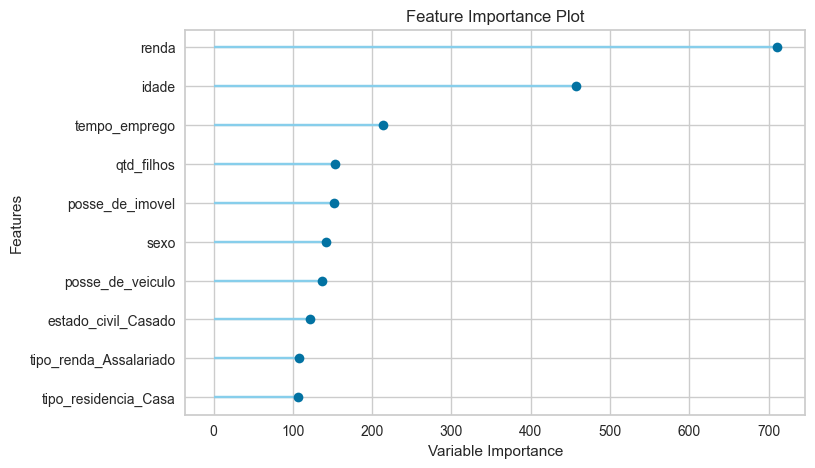

In [10]:
plot_model(lgbm, plot='feature')

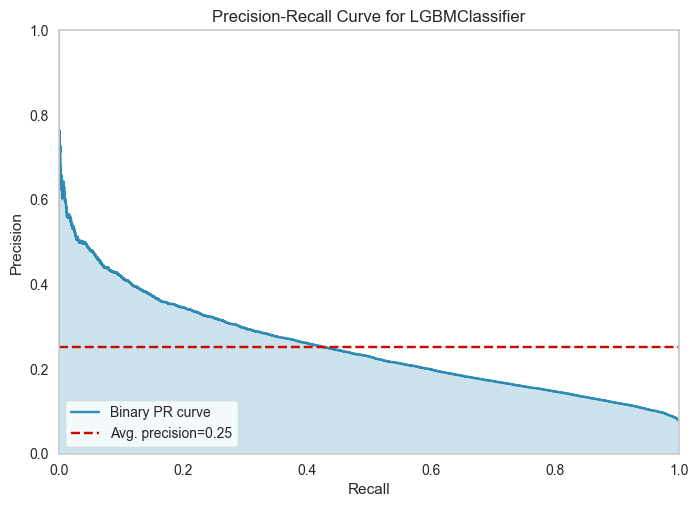

In [11]:
plot_model(lgbm, plot='pr')

O modelo LightGBM apresentou boa performance geral, com acurácia próxima de 91% e AUC de aproximadamente 0.78.
A análise da Feature Importance mostra que variáveis financeiras e de estabilidade (renda, idade e tempo de emprego) são as mais relevantes, o que está alinhado com o problema de credit scoring.
A curva Precision-Recall indica que o modelo possui poder discriminativo acima do aleatório, embora exista um trade-off natural entre precisão e recall, típico de bases desbalanceadas.
Dependendo da estratégia de negócio, o limiar de decisão pode ser ajustado para priorizar maior recall ou maior precisão.